# Fun with Hidden Markov Models
*by Loren Lugosch*

## HMM main class

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import numpy as np

class HMM(torch.nn.Module):
  """
  Hidden Markov Model with discrete observations.
  """
  def __init__(self, N, distributions, transition_matrix=None, state_priors='uniform'):
    super(HMM, self).__init__()
    #self.M = M # number of possible observations
    self.N = N # number of states

    # A
    self.transition_model = TransitionModel(self.N, transition_matrix)

    # b(x_t)
    self.emission_model = EmissionModel(self.N, distributions)

    # pi # CHECK
    if state_priors=="uniform":
        self.unnormalized_state_priors = torch.ones(self.N)/self.N#torch.nn.Parameter(torch.randn(self.N))#torch.randn(self.N)#
        self.normalized_state_priors = self.unnormalized_state_priors
        self.log_normalized_state_priors = torch.log(self.unnormalized_state_priors)
    elif state_priors=="random":
        self.unnormalized_state_priors = torch.randn(self.N)
        self.normalized_state_priors = torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
        self.log_normalized_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
    elif torch.is_tensor(state_priors):
        self.unnormalized_state_priors = state_priors
        self.normalized_state_priors = torch.nn.functional.normalize(self.unnormalized_transition_matrix, p=1, dim=0)
        self.log_normalized_state_priors = torch.log(self.normalized_state_priors)
    else:
        raise ValueError("state_priors must be 'uniform', 'random' or torch tensor")


    # use the GPU
    self.is_cuda = torch.cuda.is_available()
    if self.is_cuda: self.cuda()

class TransitionModel(torch.nn.Module):
  def __init__(self, N, transition_matrix=None):
    super(TransitionModel, self).__init__()
    self.N = N
    if transition_matrix is None:
        self.unnormalized_transition_matrix = torch.nn.functional.softmax(torch.randn(N,N), dim=1)#torch.nn.Parameter(torch.randn(N,N))# CHECK
    else:
        self.unnormalized_transition_matrix = transition_matrix
  def normalized_transition_matrix(self):
      #return torch.nn.functional.softmax(self.unnormalized_transition_matrix, dim=1) ## CHECK # original dim=0
      return torch.nn.functional.normalize(self.unnormalized_transition_matrix, p=1, dim=1)
  def log_normalized_transition_matrix(self):
      #return torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=1) ## CHECK 
      return torch.log(self.normalized_transition_matrix())

class EmissionModel(torch.nn.Module):
  def __init__(self, N, distributions):
    super(EmissionModel, self).__init__()
    self.N = N
    self.distributions = distributions ## list of distributions

  def pdf(self, hidden_state, observation):
    current_distribution = self.distributions[hidden_state]
    return torch.exp(current_distribution.log_prob(torch.Tensor(observation)))



## Sampling

In [3]:
def sample(self, T=10):
  state_priors = self.normalized_state_priors#torch.nn.functional.softmax(self.unnormalized_state_priors, dim=0)
  transition_matrix = self.transition_model.normalized_transition_matrix()
  #emission_matrix = torch.nn.functional.softmax(self.emission_model.unnormalized_emission_matrix, dim=1)

  # sample initial state
  z_t = torch.distributions.categorical.Categorical(state_priors).sample().item()
  z = []; x = []
  z.append(z_t)
  for t in range(0,T):
    # sample emission
    # x_t = torch.distributions.categorical.Categorical(emission_matrix[z_t]).sample().item()
    current_distribution = self.emission_model.distributions[z_t]
    x_t = current_distribution.sample()
    x.append(x_t)

    # sample transition
    z_t = torch.distributions.categorical.Categorical(transition_matrix[z_t, :]).sample().item() # CHECK # original [:, z_t]
    if t < T-1: z.append(z_t)
 
  return torch.stack(x), z

# Add the sampling method to our HMM class
HMM.sample = sample

#### One dimentional sampling test

In [4]:
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])

In [5]:
x, z = test_model.sample(20)

In [6]:
test_model.transition_model.normalized_transition_matrix()

tensor([[0.2177, 0.7823],
        [0.3549, 0.6451]])

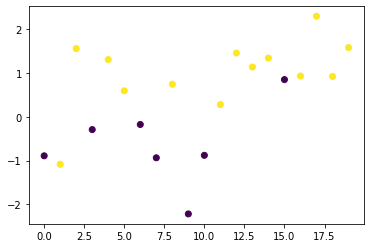

In [7]:

plt.scatter(list(range(len(x))),x, c=z)

In [8]:
x,z

(tensor([-0.8920, -1.0858,  1.5560, -0.2934,  1.3053,  0.5925, -0.1767, -0.9373,
          0.7423, -2.2184, -0.8806,  0.2780,  1.4543,  1.1349,  1.3406,  0.8484,
          0.9296,  2.2947,  0.9204,  1.5789]),
 [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

#### two dimentional sampling test

In [9]:
test_model = HMM(2, [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))])

In [10]:
x, z = test_model.sample(200)

In [11]:
test_model.transition_model.normalized_transition_matrix()


tensor([[0.1157, 0.8843],
        [0.4665, 0.5335]])

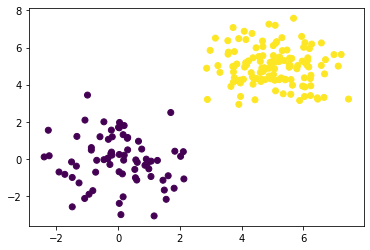

In [12]:
plt.scatter(x[:,0],x[:,1], c=z)

Let's try hard-coding an HMM for generating fake words. (We'll also add some helper functions for encoding and decoding strings.)

We will assume that the system has one state for generating vowels and one state for generating consonants, and the transition matrix has 0s on the diagonal---in other words, the system cannot stay in the vowel state or the consonant state for one than one timestep; it has to switch.

Since we pass the transition matrix through a softmax, to get 0s we set the unnormalized parameter values to $-\infty$.

In [13]:
test_distr = distrib.Normal(5,1)

In [14]:
torch.exp(test_distr.log_prob(torch.Tensor([4])))

tensor([0.2420])

In [15]:
x = np.linspace(0, 10, 1000)


In [16]:
q0_density = torch.exp(test_distr.log_prob(torch.Tensor(x))).numpy()


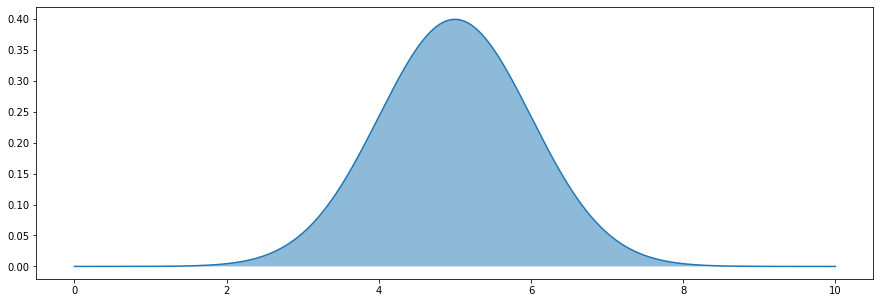

In [17]:
fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)



## The Three Problems

In a [classic tutorial](https://www.cs.cmu.edu/~cga/behavior/rabiner1.pdf) on HMMs, Lawrence Rabiner describes "three problems" that need to be solved before you can effectively use an HMM. They are:
- Problem 1: How do we efficiently compute $p(\mathbf{x})$?
- Problem 2: How do we find the most likely state sequence $\mathbf{z}$ that could have generated the data? 
- Problem 3: How do we train the model?

In the rest of the notebook, we will see how to solve each problem and implement the solutions in PyTorch.

### Problem 1: How do we compute $p(\mathbf{x})$?

________

<u><b>The Forward Algorithm</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\alpha_{s,1} := b_s(x_1) \cdot \pi_s$ 
> 
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
> $\alpha_{s,t} := b_s(x_t) \cdot \underset{s'}{\sum} A_{s, s'} \cdot \alpha_{s',t-1} $
> 
> $p(\mathbf{x}) := \underset{s}{\sum} \alpha_{s,T}$\
> return $p(\mathbf{x})$
________


The forward algorithm is much faster than enumerating all $N^T$ possible state sequences: it requires only $O(N^2T)$ operations to run, since each step is mostly multiplying the vector of forward variables by the transition matrix. (And very often we can reduce that complexity even further, if the transition matrix is sparse.)

There is one practical problem with the forward algorithm as presented above: it is prone to underflow due to multiplying a long chain of small numbers, since probabilities are always between 0 and 1. Instead, let's do everything in the log domain. In the log domain, a multiplication becomes a sum, and a sum becomes a [logsumexp](https://lorenlugosch.github.io/posts/2020/06/logsumexp/).  

________

<u><b>The Forward Algorithm (Log Domain)</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\text{log }\alpha_{s,1} := \text{log }b_s(x_1) + \text{log }\pi_s$ 
> 
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
> $\text{log }\alpha_{s,t} := \text{log }b_s(x_t) +  \underset{s'}{\text{logsumexp}} \left( \text{log }A_{s, s'} + \text{log }\alpha_{s',t-1} \right)$
> 
> $\text{log }p(\mathbf{x}) := \underset{s}{\text{logsumexp}} \left( \text{log }\alpha_{s,T} \right)$\
> return $\text{log }p(\mathbf{x})$
________

Now that we have a numerically stable version of the forward algorithm, let's implement it in PyTorch. 

## Forward

In [18]:

def HMM_forward(self, x, T, save_log_alpha=True):
  """
  x : IntTensor of shape (batch size, T_max)
  T : IntTensor of shape (batch size)

  Compute log p(x) for each example in the batch.
  T = length of each example
  """
  if self.is_cuda:
  	x = x.cuda()
  	T = T.cuda()

  batch_size = x.shape[0]; T_max = x.shape[1]
  #log_state_priors = torch.log(self.unnormalized_state_priors)  # TODO #torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  #log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  log_state_priors = self.log_normalized_state_priors
  log_alpha = torch.zeros(batch_size, T_max, self.N) # table (sample, t, state) containing log probability of observations from sample to time t and being in state (in time t)
  if self.is_cuda: log_alpha = log_alpha.cuda()

  #print(log_state_priors)
  log_alpha[:, 0, :] = self.emission_model(x[:,0]) + log_state_priors # emission_model - log prob for each distr
  for t in range(1, T_max):
    #print(f"t={t} ", self.emission_model(x[:,t]), self.transition_model(log_alpha[:, t-1, :]))
    log_alpha[:, t, :] = self.emission_model(x[:,t]) + self.transition_model(log_alpha[:, t-1, :])

  if save_log_alpha:
    self.log_alpha = log_alpha
    self.x = x
  # Select the sum for the final timestep (each x may have different length).
  #print("alpha\n", log_alpha)
  log_sums = log_alpha.logsumexp(dim=2)
  #print("log_sums\n", log_sums)
  #log_probs = torch.gather(log_sums, 1, T.view(1,-1))
  log_probs = torch.gather(log_sums, 1, T.view(-1,1)-1)
  return log_probs

def emission_model_forward(self, x_t): ## TODO
  #out = self.distributions.log_prob(x_t)
  #out = 
  out  = []
  for state in range(self.N):
    out.append( self.distributions[state].log_prob(x_t) )
  result = torch.stack(out, dim = 1)
  #print("emission probs\n",result)
  return result

def transition_model_forward(self, log_alpha):
  """
  log_alpha : Tensor of shape (batch size, N)
  Multiply previous timestep's alphas by transition matrix (in log domain)
  """
  log_transition_matrix = self.log_normalized_transition_matrix()

  # Matrix multiplication in the log domain
  out = log_domain_matmul(log_transition_matrix.transpose(0,1), log_alpha.transpose(0,1)).transpose(0,1) # CHECK # original log_transition_matrix
  return out

def log_domain_matmul(log_A, log_B):
	"""
	log_A : m x n
	log_B : n x p
	output : m x p matrix

	Normally, a matrix multiplication
	computes out_{i,j} = sum_k A_{i,k} x B_{k,j}

	A log domain matrix multiplication
	computes out_{i,j} = logsumexp_k log_A_{i,k} + log_B_{k,j}
	"""
	m = log_A.shape[0]#; print(log_A.shape, log_B.shape)
	n = log_A.shape[1]
	p = log_B.shape[1]
    #print(log_A.shape, log_B.shape)
    # log_A_expanded = torch.stack([log_A] * p, dim=2)
	# log_B_expanded = torch.stack([log_B] * m, dim=0)
    # fix for PyTorch > 1.5 by egaznep on Github:
	log_A_expanded = torch.reshape(log_A, (m,n,1))#; print(log_A_expanded.shape)
	log_B_expanded = torch.reshape(log_B, (1,n,p))#; print(log_B_expanded.shape)

	elementwise_sum = log_A_expanded + log_B_expanded #; print("hello")
	out = torch.logsumexp(elementwise_sum, dim=1)#;print(out.shape)
 
	return out

TransitionModel.forward = transition_model_forward
EmissionModel.forward = emission_model_forward
HMM.forward = HMM_forward

#### Test forward method

In [19]:
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])

In [20]:
test_model.transition_model.normalized_transition_matrix()

tensor([[0.2893, 0.7107],
        [0.3376, 0.6624]])

In [21]:
x, states = test_model.sample(30)

In [22]:
#T =torch.Tensor([10,10,10], dtype= torch.int64)
T = torch.ones([1,3], dtype=torch.int64)*10
T.view(-1, 1)

tensor([[10],
        [10],
        [10]])

In [23]:
test_model(torch.reshape(x, (3, 10)), T)

tensor([[-17.4672],
        [-13.7889],
        [-14.6965]])

### Problem 2: How do we compute $\underset{\mathbf{z}}{\text{argmax }} p(\mathbf{z}|\mathbf{x})$?

________

<u><b>The Viterbi Algorithm</b></u>

> for $s=1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta_{s,1} := b_s(x_1) \cdot \pi_s$\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\psi_{s,1} := 0$
>
> for $t = 2 \rightarrow T$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for $s = 1 \rightarrow N$:\
> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\delta_{s,t} := b_s(x_t) \cdot \left( \underset{s'}{\text{max }} A_{s, s'} \cdot \delta_{s',t-1} \right)$\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\psi_{s,t} := \underset{s'}{\text{argmax }} A_{s, s'} \cdot \delta_{s',t-1}$
> 
> $z_T^* := \underset{s}{\text{argmax }} \delta_{s,T}$\
> for $t = T-1 \rightarrow 1$:\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$z_{t}^* := \psi_{z_{t+1}^*,t+1}$
> 
> $\mathbf{z}^* := \{z_{1}^*, \dots, z_{T}^* \}$\
return $\mathbf{z}^*$
________

The Viterbi algorithm looks somewhat gnarlier than the forward algorithm, but it is essentially the same algorithm, with two tweaks: 1) instead of taking the sum over previous states, we take the max; and 2) we record the argmax of the previous states in a table, and loop back over this table at the end to get $\mathbf{z}^*$, the most likely state sequence. (And like the forward algorithm, we should run the Viterbi algorithm in the log domain for better numerical stability.) 

Let's add the Viterbi algorithm to our PyTorch model:

## Viterbi

In [24]:
def viterbi(self, x, T):
  """
  x : IntTensor of shape (batch size, T_max)
  T : IntTensor of shape (batch size)
  Find argmax_z log p(x|z) for each (x) in the batch.
  """
  if self.is_cuda:
    x = x.cuda()
    T = T.cuda()

  batch_size = x.shape[0]; T_max = x.shape[1]
  log_state_priors = self.log_normalized_state_priors#torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  log_delta = torch.zeros(batch_size, T_max, self.N).float()
  psi = torch.zeros(batch_size, T_max, self.N).long()
  if self.is_cuda:
    log_delta = log_delta.cuda()
    psi = psi.cuda()

  log_delta[:, 0, :] = self.emission_model(x[:,0]) + log_state_priors
  for t in range(1, T_max):
    max_val, argmax_val = self.transition_model.maxmul(log_delta[:, t-1, :])
    log_delta[:, t, :] = self.emission_model(x[:,t]) + max_val
    psi[:, t, :] = argmax_val

  # Get the log probability of the best path
  log_max = log_delta.max(dim=2)[0]
  best_path_scores = torch.gather(log_max, 1, T.view(-1,1) - 1)

  # This next part is a bit tricky to parallelize across the batch,
  # so we will do it separately for each example.
  z_star = []
  for i in range(0, batch_size):
    z_star_i = [ log_delta[i, T[i] - 1, :].max(dim=0)[1].item() ]
    for t in range(T[i] - 1, 0, -1):
      z_t = psi[i, t, z_star_i[0]].item()
      z_star_i.insert(0, z_t)

    z_star.append(z_star_i)

  return z_star, best_path_scores # return both the best path and its log probability

def transition_model_maxmul(self, log_alpha):
  log_transition_matrix = self.log_normalized_transition_matrix()#torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

  out1, out2 = maxmul(log_transition_matrix.transpose(0,1), log_alpha.transpose(0,1)) # CHECK # original log_transition_matrix
  return out1.transpose(0,1), out2.transpose(0,1)

def maxmul(log_A, log_B):
	"""
	log_A : m x n
	log_B : n x p
	output : m x p matrix

	Similar to the log domain matrix multiplication,
	this computes out_{i,j} = max_k log_A_{i,k} + log_B_{k,j}
	"""
	m = log_A.shape[0]
	n = log_A.shape[1]
	p = log_B.shape[1]

	log_A_expanded = torch.stack([log_A] * p, dim=2)
	log_B_expanded = torch.stack([log_B] * m, dim=0)

	elementwise_sum = log_A_expanded + log_B_expanded
	out1,out2 = torch.max(elementwise_sum, dim=1)

	return out1,out2

TransitionModel.maxmul = transition_model_maxmul
HMM.viterbi = viterbi

### Test viterbi

In [25]:
test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])

In [26]:
x, states = test_model.sample(10)

In [27]:
x, states

(tensor([ 0.5706,  1.1633, -2.8348,  0.6107,  1.1169, -1.5652,  0.6840,  1.0202,
         -1.0780,  2.4471]), [0, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [28]:
T = torch.ones([1], dtype=torch.int64)*10


In [29]:
viterbi_results = test_model.viterbi(torch.reshape(x, (1, 10)), T)

In [30]:
viterbi_results

([[1, 1, 0, 1, 1, 0, 1, 1, 0, 1]], tensor([[-17.9896]]))

In [31]:
test_model.forward(torch.reshape(x, (1, 10)), T)

tensor([[-17.0662]])

In [32]:
states

[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]

The two scores are the same! That's because in this instance there is only one possible path through the HMM, so the probability of the most likely path is the same as the sum of the probabilities of all possible paths.

In general, though, the forward score and Viterbi score will always be somewhat close. This is because of a property of the $\text{logsumexp}$ function: $\text{logsumexp}(\mathbf{x}) \approx \max (\mathbf{x})$. ($\text{logsumexp}$ is sometimes referred to as the "smooth maximum" function.)

In [33]:
x = torch.tensor([1., 2., 3.])
print(x.max(dim=0)[0])
print(x.logsumexp(dim=0))

tensor(3.)
tensor(3.4076)


### Problem 3: How do we train the model?





## Backward

In [34]:
def HMM_backward(self, x, T, save_log_beta=True):
  """
  x : IntTensor of shape (batch size, T_max)
  T : IntTensor of shape (batch size)

  Compute backward log p(x) for each example in the batch.
  T = length of each example
  """
  if self.is_cuda:
  	x = x.cuda()
  	T = T.cuda()

  batch_size = x.shape[0]; T_max = x.shape[1] - 1
  gather_indexes = torch.zeros((batch_size,1), dtype=torch.int64)
  if self.is_cuda:
    gather_indexes = gather_indexes.cuda()
  #log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  log_beta = torch.zeros(batch_size, T_max+1, self.N) # table (sample, t, state) containing log probability of observations from sample from time t+1 to T_max and being in state (in time t)
  if self.is_cuda: log_beta = log_beta.cuda()

  log_transition_matrix = self.transition_model.log_normalized_transition_matrix() #torch.nn.functional.log_softmax(self.transition_model.unnormalized_transition_matrix, dim=0)

  log_beta[:, T_max, :] = 0 #1 #self.emission_model(x[:,0]) + log_state_priors # emission_model - log prob for each distr
  for t in range(T_max-1, 0-1, -1):
    suma = (self.emission_model(x[:,t+1])+log_beta[:, t+1, :]).transpose(1,0)
    #print(suma.shape)
    #suma = suma.unsqueeze(1)
    #print(suma.shape)
    out = log_domain_matmul(log_transition_matrix, suma).transpose(1,0)# CHECK # original log_transition_matrix
    #print(out.shape, log_beta[:, t, :].shape)
    log_beta[:, t, :] = out

  if save_log_beta:
    self.log_beta = log_beta
    self.x = x

  log_state_priors = torch.nn.functional.log_softmax(self.unnormalized_state_priors, dim=0)
  termination = self.emission_model(x[:,0]) + log_state_priors + log_beta[:, 0, :]

  log_sums = log_beta.logsumexp(dim=2)
  #print("log_sums\n", log_sums)
  #log_probs = torch.gather(log_sums, 1, T.view(1,-1))
  #log_probs = torch.gather(log_sums, 1, gather_indexes)
  log_probs = termination.logsumexp(dim=1)
  return log_probs

# def transition_model_backward(self, log_beta):
#   """
#   log_alpha : Tensor of shape (batch size, N)
#   Multiply previous timestep's alphas by transition matrix (in log domain)
#   """
#   log_transition_matrix = torch.nn.functional.log_softmax(self.unnormalized_transition_matrix, dim=0)

#   # Matrix multiplication in the log domain
#   #out = log_domain_matmul(log_transition_matrix, log_alpha.transpose(0,1)).transpose(0,1)
#   out = log_domain_matmul(log_transition_matrix.transpose(0,1), log_beta.transpose(0,1)).transpose(0,1)
#   return out

#TransitionModel.back = transition_model_backward
HMM.back = HMM_backward


In [35]:
#test_model = HMM(2, [distrib.Normal(-1,1), distrib.Normal(1, 1)])
test_model = HMM(2, [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))])

In [36]:
sequence_length, n_of_sequences, sample_dim = 50, 3, 2

In [37]:
x, states = test_model.sample(sequence_length*n_of_sequences)

In [38]:
test_model.transition_model.normalized_transition_matrix()

tensor([[0.9742, 0.0258],
        [0.3597, 0.6403]])

In [39]:
#T =torch.Tensor([10,10,10], dtype= torch.int64)
T = torch.ones([n_of_sequences,1], dtype=torch.int64)*sequence_length
T.view(-1, 1)

tensor([[50],
        [50],
        [50]])

In [40]:
test_model(torch.reshape(x, (n_of_sequences, sequence_length, sample_dim)), T)

tensor([[-133.8017],
        [-154.6518],
        [-132.3757]])

In [41]:
test_model.back(torch.reshape(x, (n_of_sequences, sequence_length, sample_dim)), T)

tensor([-133.8017, -154.6519, -132.3757])

## Forward - Backward

In [42]:
def forward_backward_step(self, x, T):
    T_max=10
    forward_result = self.forward(x, T, save_log_alpha=True)
    backward_result = self.back(x, T, save_log_beta=True)
    #log_beta and alpha have shape: (batch_size, T_max, self.N)
    denominator_sum = (self.log_alpha+self.log_beta).logsumexp(dim=2)[:, 0:T_max-1]
    log_alpha = self.log_alpha[:, 0:(T_max-1),:].unsqueeze(3)
    log_beta = self.log_beta[:, 1:T_max, :].unsqueeze(2)
    log_b = self.emission_model(x)
    #print(log_b.shape)
    log_b = log_b.transpose(1,2)[:, 1:T_max, :].unsqueeze(2)
    log_transition_matrix = self.transition_model.log_normalized_transition_matrix()#torch.nn.functional.log_softmax(self.transition_model.unnormalized_transition_matrix, dim=0).unsqueeze(0).unsqueeze(1)
    #print(log_transition_matrix.shape, log_b.shape, log_transition_matrix.shape, log_alpha.shape)

    nominator = log_alpha+log_transition_matrix+log_beta+log_b # CHECK
    #print(nominator.shape)
    log_ksi = nominator - denominator_sum[:, 0:T_max-1].unsqueeze(2).unsqueeze(3)
    

    approx_log_A = log_ksi.logsumexp(dim=(0,1)) 
    approx_log_A = approx_log_A - log_ksi.logsumexp(dim=(0,1,3)).unsqueeze(1)
    approx_A = torch.exp(approx_log_A)#.transpose(0,1)#### Czy chcemy ten transpose CHECK originaly no transpose
    self.transition_model.unnormalized_transition_matrix = approx_A

    return approx_A


HMM.forward_backward_step = forward_backward_step

In [43]:
test_model.transition_model.unnormalized_transition_matrix 

tensor([[0.9742, 0.0258],
        [0.3597, 0.6403]])

In [44]:
result = test_model.forward_backward_step(torch.reshape(x, (n_of_sequences, sequence_length, sample_dim)), T)
result.shape

torch.Size([2, 2])

In [45]:
result

tensor([[1.0000e+00, 1.6484e-08],
        [3.3333e-01, 6.6667e-01]])

In [46]:
test_model.transition_model.unnormalized_transition_matrix

tensor([[1.0000e+00, 1.6484e-08],
        [3.3333e-01, 6.6667e-01]])

In [47]:
for i in range(10):
    result = test_model.forward_backward_step(torch.reshape(x, (n_of_sequences, sequence_length, sample_dim)), T)
    print(result)


tensor([[1.0000e+00, 9.2803e-15],
        [3.3333e-01, 6.6667e-01]])
tensor([[1.0000e+00, 5.2248e-21],
        [3.3333e-01, 6.6667e-01]])
tensor([[1.0000e+00, 2.9416e-27],
        [3.3333e-01, 6.6667e-01]])
tensor([[1.0000e+00, 1.6561e-33],
        [3.3333e-01, 6.6667e-01]])
tensor([[1.0000e+00, 9.3240e-40],
        [3.3333e-01, 6.6667e-01]])
tensor([[1.0000, 0.0000],
        [0.3333, 0.6667]])
tensor([[1.0000, 0.0000],
        [0.3333, 0.6667]])
tensor([[1.0000, 0.0000],
        [0.3333, 0.6667]])
tensor([[1.0000, 0.0000],
        [0.3333, 0.6667]])
tensor([[1.0000, 0.0000],
        [0.3333, 0.6667]])


In [48]:
result

tensor([[1.0000, 0.0000],
        [0.3333, 0.6667]])

### Test of optimization of matrix

In [79]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, distributions, device, T=1000, sequence_length=100,transition_matrix=None):
        self.device = device
        self.sequence_length = sequence_length
        self.T = T
        self.MyHMM = HMM(len(distributions), distributions,transition_matrix=transition_matrix)
        self.data_dim = distributions[0].sample().shape[0]
        self.generate_sequence()

    def generate_sequence(self): # TODO zmienic! - chcemy mieć T sekwencji wygenerowanych za pomocą HMM.sample(self.sequence_length)
        
        self.train_X = torch.zeros((self.T, self.sequence_length, self.data_dim))
        self.train_Z = torch.zeros((self.T, self.sequence_length))
        for i in range(self.T):
            x, z = self.MyHMM.sample(self.sequence_length)
            self.train_X[i, :, :] = x
            self.train_Z[i, :] = torch.tensor(z, dtype=torch.int)

        self.test_T = int(0.2*self.T)
        self.test_X = torch.zeros((self.test_T, self.sequence_length, self.data_dim))
        self.test_Z = torch.zeros((self.test_T, self.sequence_length))
        for i in range(self.test_T):
            x, z = self.MyHMM.sample(self.sequence_length)
            self.test_X[i, :, :] = x
            self.test_Z[i, :] = torch.tensor(z, dtype=torch.int)

    def __len__(self):
        return self.T

    def __getitem__(self, index):
        t = self.train_X[index]
        t.to(device)
        return t



In [80]:

#my_dataset = ArtificialDataset([distrib.Normal(-1,0.1), distrib.Normal(2, 0.1)], device, T=100000)
my_dataset = ArtificialDataset(
    [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))],
    device, 
    T=5, sequence_length = 20,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.7, 0.3]]))
samples = my_dataset[1:len(my_dataset)]

2
torch.Size([5, 20, 2])


In [81]:
my_dataset.train_Z

tensor([[0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
         1., 0.],
        [1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
         0., 1.],
        [0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
         0., 1.],
        [1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
         0., 1.],
        [0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
         1., 0.]])

In [83]:
#my_dataset = ArtificialDataset([distrib.Normal(-1,0.1), distrib.Normal(2, 0.1)], device, T=100000)
my_dataset = ArtificialDataset(
    [distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))],
    device, 
    T=1000,
    transition_matrix=torch.Tensor([[0.1,0.9], [0.7, 0.3]]))
samples = my_dataset[1:len(my_dataset)]
#plt.scatter(samples[:,0], samples[:,1])

2
torch.Size([1000, 100, 2])


In [84]:
my_dataset.MyHMM.transition_model.normalized_transition_matrix()

tensor([[0.1000, 0.9000],
        [0.7000, 0.3000]])

In [85]:
HMM_to_train = HMM(2,[distrib.MultivariateNormal(torch.zeros(2),torch.eye(2)), distrib.MultivariateNormal(torch.ones(2)*5,torch.eye(2))], 
                   transition_matrix = torch.Tensor([[0.49,0.51],[0.55, 0.45]]))

In [86]:
HMM_to_train.transition_model.normalized_transition_matrix()

tensor([[0.4900, 0.5100],
        [0.5500, 0.4500]])

In [94]:
sequence_length, n_of_sequences, sample_dim = 100, 1000, 2
batch_size = 500

In [95]:
from torch.utils.data import DataLoader
# dataset is class inheriting from torch.utils.data.Dataset
for epoch in range(10):
    #my_dataset.generate_sequence()
    dataloader = DataLoader(my_dataset, batch_size= batch_size)
    for batch, x in enumerate(dataloader):
        #torch.reshape(x, (3, 10)), T
        T = torch.ones([batch_size,1], dtype=torch.int64)*my_dataset.sequence_length
        HMM_to_train.forward_backward_step(x, T)
        print(HMM_to_train.transition_model.normalized_transition_matrix())
    if epoch%1==0:
        #print("NEW")
        print(HMM_to_train.transition_model.normalized_transition_matrix())

tensor([[0.0983, 0.9017],
        [0.7082, 0.2918]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0983, 0.9017],
        [0.7082, 0.2918]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0983, 0.9017],
        [0.7082, 0.2918]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0983, 0.9017],
        [0.7082, 0.2918]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0983, 0.9017],
        [0.7082, 0.2918]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0983, 0.9017],
        [0.7082, 0.2918]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0952, 0.9048],
        [0.6832, 0.3168]])
tensor([[0.0983, 0.9017],
        [0.7082, 0.2

In [93]:
HMM_to_train.transition_model.normalized_transition_matrix()

tensor([[0.0622, 0.9378],
        [0.6737, 0.3263]])

In [ ]:
samples

# Test for forward

In [ ]:
import torch

def create_simple_distr(prob):
    #return torch.distributions.bernoulli.Bernoulli(torch.tensor([prob]))
    return torch.distributions.Normal(prob, 1)

def compute_log_lieklihood():
    a_1_0 = 0.5 * prob0
    a_1_1 = 0.5 * prob1
    a_2_0 = a_1_0 * transition_matrix[0,0] * prob0 + a_1_1 * transition_matrix[1,0] * prob0
    a_2_1 = a_1_0 * transition_matrix[0,1] * prob1 + a_1_1 * transition_matrix[1,1] * prob1 
    a_3_0 = a_2_0 * transition_matrix[0,0] * prob0 + a_2_1 * transition_matrix[1,0] * prob0
    a_3_1 = a_2_0 * transition_matrix[0,1] * prob1 + a_2_1 * transition_matrix[1,1] * prob1
    results = [[a_1_0, a_1_1], [a_2_0, a_2_1], [a_3_0, a_3_1]]
    print(np.log(a_1_0 * 0.2), np.log(a_1_1 * 0.2) )
    print(results)
    return np.log(results), np.log(a_3_0 + a_3_1)

def compute_log_lieklihood_in_log():
    a_1_0 = np.log(0.5) * log_prob_0
    a_1_1 = np.log(0.5) * log_prob_1
    a_2_0 = np.log(np.exp(a_1_0 + np.log(transition_matrix[0,0]) + log_prob_0) + np.exp(a_1_1 + np.log(transition_matrix[0,1]) + log_prob_1))
    a_2_1 = np.log(np.exp(a_1_0 + np.log(transition_matrix[1,0]) + log_prob_0) + np.exp(a_1_1 + np.log(transition_matrix[1,1]) + log_prob_1))
    a_3_0 = np.log(np.exp(a_2_0 + np.log(transition_matrix[0,0]) + log_prob_0) + np.exp(a_2_1 + np.log(transition_matrix[1,1]) + log_prob_1))

    a_3_0 = a_2_0 * transition_matrix[0,0] * prob0 + a_2_1 * transition_matrix[0,1] * prob1
    a_3_1 = a_2_0 * 0.8 * transition_matrix[1,0] + a_2_1 * 0.8 * transition_matrix[1,1]
    results = [[a_1_0, a_1_1], [a_2_0, a_2_1], [a_3_0, a_3_1]]
    return results, np.log(np.exp(a_3_0) + np.exp(a_3_1))

transition_matrix = torch.tensor([[0.2,0.8], [0.2,0.8]])
initial_distr = torch.tensor([0.5, 0.5])

#prob0 = 0.1 # 10% chance for 1, otherwise 0
#prob1 = 0.9
observations = torch.tensor([[1, 1, 1]])
#d_0 = create_simple_distr(prob0)
#d_1 = create_simple_distr(prob1)
mu_0, mu_1 = 0,1
d_0 = create_simple_distr(mu_0)
d_1 = create_simple_distr(mu_1)
log_prob_0 = d_0.log_prob(torch.tensor(1))
log_prob_1 = d_1.log_prob(torch.tensor(1))
prob0 = torch.exp(d_0.log_prob(torch.tensor(1)))
prob1 = torch.exp(d_1.log_prob(torch.tensor(1)))




# data for HMM
observations = torch.tensor([[1, 1, 1]], dtype=torch.int64)
#transition_matrix = torch.tensor([[0.2, 0.8], [0.2, 0.8]])#torch.tensor([[0.2,0.2], [0.8,0.8]])
#initial_distr = torch.tensor([0.5, 0.5])
distributions = [d_0,d_1]

# TO DO
hmm = HMM(2, distributions, transition_matrix=transition_matrix)



In [ ]:
torch.set_printoptions(precision=8)

In [ ]:
torch.exp(d_0.log_prob(torch.tensor(0)))

In [ ]:
torch.exp(d_0.log_prob(torch.tensor(1)))

In [ ]:
torch.exp(d_0.log_prob(observations))

In [ ]:
torch.exp(d_1.log_prob(observations))

In [ ]:
d_0.log_prob(observations), d_1.log_prob(observations)

In [ ]:
torch.log(transition_matrix)

In [ ]:
torch.ones([1,1], dtype=torch.int64)*3

In [ ]:
torch.log(initial_distr)

In [ ]:
hmm.transition_model.unnormalized_transition_matrix

In [ ]:
hmm(observations, torch.tensor([[3]]))

In [ ]:
torch.exp(hmm.log_alpha)

In [ ]:
target_result = compute_log_lieklihood()
target_result

In [ ]:
hmm.back(observations, torch.tensor([[3]]))

In [ ]:
hmm.log_alpha

In [ ]:
assert torch.allclose(torch.tensor([[compute_log_lieklihood()[1]]]), hmm(observations, torch.tensor([[3]], dtype=torch.int64)))